In [1]:
#import libraries
import numpy as np 
import tensorflow as tf 
import keras 
import matplotlib.pyplot as plt 
import PIL 
import PIL.Image
import os 
import pathlib
import math 


In [2]:
#Hyper parameters 
batch_size=32
img_height=224
img_width=224
lr_rate= 1e-3
lr_mode='cos'
epochs=30
data_dir=pathlib.Path("/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold1_AUG/Train").with_suffix('')

 # Data Preprocessing 

In [3]:
train_ds=tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     validation_split=0.2,
                                                     subset='training',
                                                     seed=123,
                                                     image_size=(img_height,img_width),
                                                     batch_size=batch_size
    
                                                    )
val_ds=tf.keras.utils.image_dataset_from_directory(data_dir,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=123,
                                                  image_size=(img_height,img_width),
                                                  batch_size=batch_size
                                                  )
class_names=train_ds.class_names
print(class_names)

Found 7518 files belonging to 6 classes.
Using 6015 files for training.
Found 7518 files belonging to 6 classes.
Using 1503 files for validation.
['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']


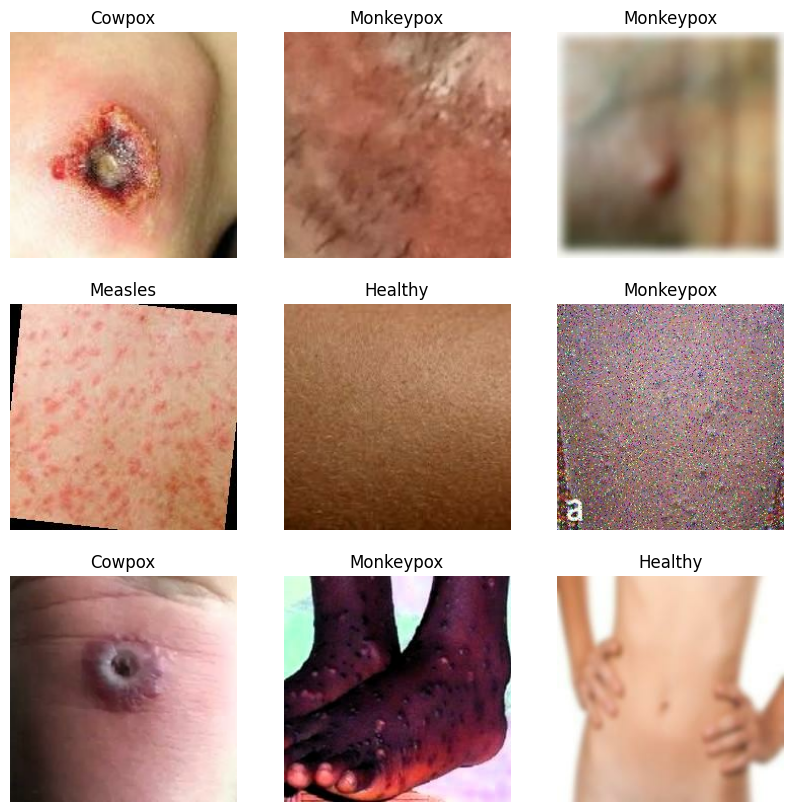

In [4]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("OFF")

In [5]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [6]:
# Autotune 

autotune=tf.data.AUTOTUNE
train_ds=train_ds.cache().prefetch(buffer_size=autotune)
val_ds=val_ds.cache().prefetch(buffer_size=autotune)

# Normalization 

In [7]:
normalization_layer=tf.keras.layers.Rescaling(1./255)
normalized_ds=train_ds.map(lambda x,y:(normalization_layer(x),y))

image_batch,labels_batch=next(iter(normalized_ds))
first_image=image_batch[0]

#Notice the pixel values are now in [0,1]
print(np.min(first_image),np.max(first_image))

0.0 1.0


# Apply model ResNet50

In [8]:
base_model= keras.applications.ResNet50(weights='imagenet',
                                       include_top=False,
                                       input_shape=(img_width,img_height,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
base_model.trainable=False 

In [10]:
inputs=keras.Input(shape=(img_width,img_height,3))
x=base_model(inputs,training=False)
x=keras.layers.Conv2D(512,3,padding='same',activation='relu')(x)
x=keras.layers.GlobalAveragePooling2D()(x)
x=keras.layers.Dense(256,activation='relu')(x)
outputs=keras.layers.Dense(6)(x)
model_RestNet=keras.Model(inputs,outputs)

In [11]:
model_RestNet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 512)      │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,158,278 (126.49 MB)

 Trainable params: 9,570,566 (36.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

model_RestNet.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_rate),loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             
             )

In [13]:
history=model_RestNet.fit(train_ds,
                 epochs=epochs,
                 callbacks=[early_stopping],
                 validation_data=train_ds
                 )

Epoch 1/30


I0000 00:00:1727033178.318001      74 service.cc:145] XLA service 0x7c62b0053320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727033178.318059      74 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727033178.318063      74 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/188 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.2031 - loss: 4.7655 

I0000 00:00:1727033186.105922      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 59s 237ms/step - accuracy: 0.6399 - loss: 1.9091 - val_accuracy: 0.9275 - val_loss: 0.2040
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 32s 171ms/step - accuracy: 0.9174 - loss: 0.2264 - val_accuracy: 0.9367 - val_loss: 0.1730
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 176ms/step - accuracy: 0.9520 - loss: 0.1394 - val_accuracy: 0.9421 - val_loss: 0.1843
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 34s 180ms/step - accuracy: 0.9556 - loss: 0.1235 - val_accuracy: 0.9717 - val_loss: 0.0796
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 177ms/step - accuracy: 0.9720 - loss: 0.0698 - val_accuracy: 0.9759 - val_loss: 0.0725
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 178ms/step - accuracy: 0.9798 - loss: 0.0597 - val_accuracy: 0.9779 - val_loss: 0.0649
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 178ms/step - accuracy: 0.9726 - loss: 0.0796 - val_accuracy: 0.9884 - val_loss: 0.0364
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 178ms/step - accuracy: 0.9758 - loss: 0.0597 - val

# Test Accuracy testing for RestNet

In [14]:
test_data_dir='/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold2/Test'
test_ds=tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                   seed=123,
                                                   image_size=(img_width,img_height),
                                                   batch_size=batch_size)
test_ds=test_ds.cache().prefetch(buffer_size=autotune)
test_accuracy_ResNet=model_RestNet.evaluate(test_ds)


Found 82 files belonging to 6 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9222 - loss: 0.5643


# Use VGG19

In [15]:
base_model= keras.applications.VGG19(weights='imagenet',
                                       include_top=False,
                                       input_shape=(img_width,img_height,3))

base_model.trainable=False 
inputs=keras.Input(shape=(img_width,img_height,3))
x=base_model(inputs,training=False)
x=keras.layers.Conv2D(512,3,padding='same',activation='relu')(x)
x=keras.layers.GlobalAveragePooling2D()(x)
x=keras.layers.Dense(256,activation='relu')(x)
outputs=keras.layers.Dense(6)(x)
model_VGG=keras.Model(inputs,outputs)



model_VGG.summary()






80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,517,062 (85.90 MB)

 Trainable params: 2,492,678 (9.51 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

model_VGG.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_rate),loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )
              
              
              
              

In [17]:
history=model_VGG.fit(train_ds,
                 epochs=epochs,
                 callbacks=[early_stopping],
                 validation_data=train_ds
                 )

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 87s 379ms/step - accuracy: 0.5920 - loss: 2.8711 - val_accuracy: 0.9159 - val_loss: 0.2719
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 300ms/step - accuracy: 0.8948 - loss: 0.3034 - val_accuracy: 0.9498 - val_loss: 0.1446
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 300ms/step - accuracy: 0.9465 - loss: 0.1565 - val_accuracy: 0.9380 - val_loss: 0.1664
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 299ms/step - accuracy: 0.9592 - loss: 0.1241 - val_accuracy: 0.9609 - val_loss: 0.1165
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 300ms/step - accuracy: 0.9692 - loss: 0.0862 - val_accuracy: 0.9905 - val_loss: 0.0301
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 300ms/step - accuracy: 0.9765 - loss: 0.0624 - val_accuracy: 0.9942 - val_loss: 0.0187
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 300ms/step - accuracy: 0.9914 - loss: 0.0290 - val_accuracy: 0.9355 - val_loss: 0.2001
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 300ms/step - accuracy: 0.9758 - loss: 0

# Test accuracy testing for VGG19

In [18]:
test_data_dir='/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold2/Test'
test_ds=tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                   seed=123,
                                                   image_size=(img_width,img_height),
                        
                                                   batch_size=batch_size)
test_ds=test_ds.cache().prefetch(buffer_size=autotune)
Test_accuracy_VGG=model_VGG.evaluate(test_ds)

Found 82 files belonging to 6 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.9283 - loss: 0.5915


# Plot VGG19 training Result 

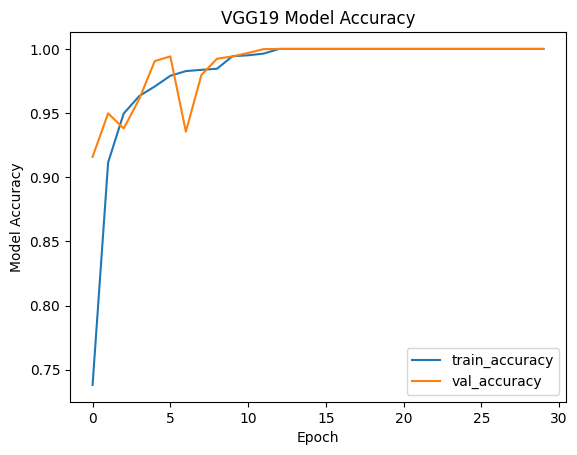

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG19 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Model Accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

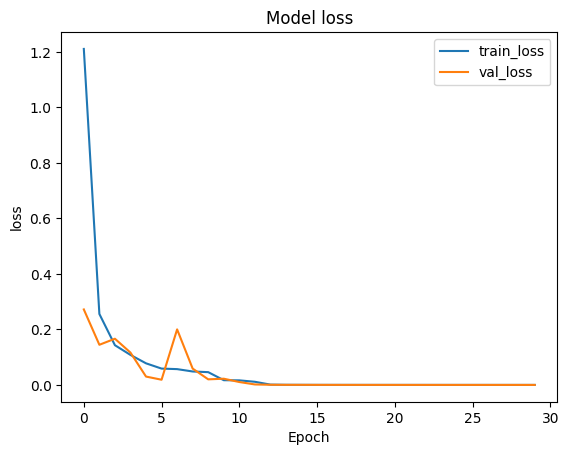

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [21]:
from keras.models import load_model
model_VGG.save('m_pox_detection.h5')